## About the datasets
<p> These datasets contain customer fit feedback collected from <a href="https://modcloth.com/">Modcloth</a>. and <a href="https://www.renttherunway.com/"> Rent the Runway</a>. As a shopper of both companies, finding the right size online is a bit challengeing and reading reviews from other women is helpful to pick out what to buy or rent. Using the subjective user data, the goal of this project is to predict fitness for associated catalog sizes. </p>
<p>First, we will look at the datasets found <a href="https://www.kaggle.com/rmisra/clothing-fit-dataset-for-size-recommendation"> here</a> by Rishabh Misra. </p>
<p> The following type of information is available in the datasets: </p>
 <ul>
  <li>ratings and reviews</li>
  <li>fit feedback (small/fit/large)</li>
  <li>customer/product measurements</li>
   <li>category information</li>
</ul>

In [1]:
# Import librarys
import pandas as pd
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr

# Suppressing all warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rc('figure', figsize = (20, 8))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes.spines', top = False, right = False)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesClassifier
import joblib
import re
import os
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC



In [2]:
# Read the file into modcloth & rtr
modcloth = pd.read_json('Desktop/size recommedations/modcloth_final_data.json', lines=True)  

# Print out modcloth 
modcloth.head()


,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29.0,7,5.0,d,38.0,34.0,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31.0,13,3.0,b,30.0,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30.0,7,2.0,b,NaN,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


## Exploring the data - Modcloth
<p> Looking at a couple rows in the dataset we can already see that there are missing values across the dataframe. These will need to be handled. There are mulitple categorical variables we will need to convert into numerical data. (cup size, hieght, shoe width) We will also want to rename the columns to remove the spaces to make them easier to use. </p>

In [3]:
#first we will change the columns
modcloth.columns

Index(['item_id', 'waist', 'size', 'quality', 'cup size', 'hips', 'bra size',
       'category', 'bust', 'height', 'user_name', 'length', 'fit', 'user_id',
       'shoe size', 'shoe width', 'review_summary', 'review_text'],
      dtype='object')

In [4]:
#rename
modcloth.columns = ['item_id', 'waist', 'size', 'quality', 'cup_size', 'hips', 'bra_size',
       'category', 'bust', 'height', 'user_name', 'length', 'fit', 'user_id',
       'shoe_size', 'shoe_width', 'review_summary', 'review_text']

#explore column info
modcloth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82790 entries, 0 to 82789
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   item_id         82790 non-null  int64  
 1   waist           2882 non-null   float64
 2   size            82790 non-null  int64  
 3   quality         82722 non-null  float64
 4   cup_size        76535 non-null  object 
 5   hips            56064 non-null  float64
 6   bra_size        76772 non-null  float64
 7   category        82790 non-null  object 
 8   bust            11854 non-null  object 
 9   height          81683 non-null  object 
 10  user_name       82790 non-null  object 
 11  length          82755 non-null  object 
 12  fit             82790 non-null  object 
 13  user_id         82790 non-null  int64  
 14  shoe_size       27915 non-null  float64
 15  shoe_width      18607 non-null  object 
 16  review_summary  76065 non-null  object 
 17  review_text     76065 non-null 

<p> We can see from the results that only 6 of the 18 columns are complete. Ones that are missing a lot could be due to the fact that specific categories need specific sizing, shoes need shoe sizes, or due to the fact that some sizes are not universal in womens clothing in the U.S. Waist size is one that can change depending on the brand and not as common as a standard size to purchase in womans clothes as it is in mens.  </p>

In [5]:
missing_data = pd.DataFrame({'total_missing': modcloth.isnull().sum(), 'missing_per': (modcloth.isnull().sum()/82790)*100})
missing_data

,total_missing,missing_per
item_id,0,0.000000
waist,79908,96.518903
size,0,0.000000
quality,68,0.082136
cup_size,6255,7.555260
hips,26726,32.281677
bra_size,6018,7.268994
category,0,0.000000
bust,70936,85.681846
height,1107,1.337118


In [6]:
#Statistical description of numerical variables
modcloth.describe()

,item_id,waist,size,quality,hips,bra_size,user_id,shoe_size
count,82790.000000,2882.000000,82790.000000,82722.000000,56064.000000,76772.000000,82790.000000,27915.000000
mean,469325.229170,31.319223,12.661602,3.949058,40.358501,35.972125,498849.564718,8.145818
std,213999.803314,5.302849,8.271952,0.992783,5.827166,3.224907,286356.969459,1.336109
min,123373.000000,20.000000,0.000000,1.000000,30.000000,28.000000,6.000000,5.000000
25%,314980.000000,28.000000,8.000000,3.000000,36.000000,34.000000,252897.750000,7.000000
50%,454030.000000,30.000000,12.000000,4.000000,39.000000,36.000000,497913.500000,8.000000
75%,658440.000000,34.000000,15.000000,5.000000,43.000000,38.000000,744745.250000,9.000000
max,807722.000000,50.000000,38.000000,5.000000,60.000000,48.000000,999972.000000,38.000000


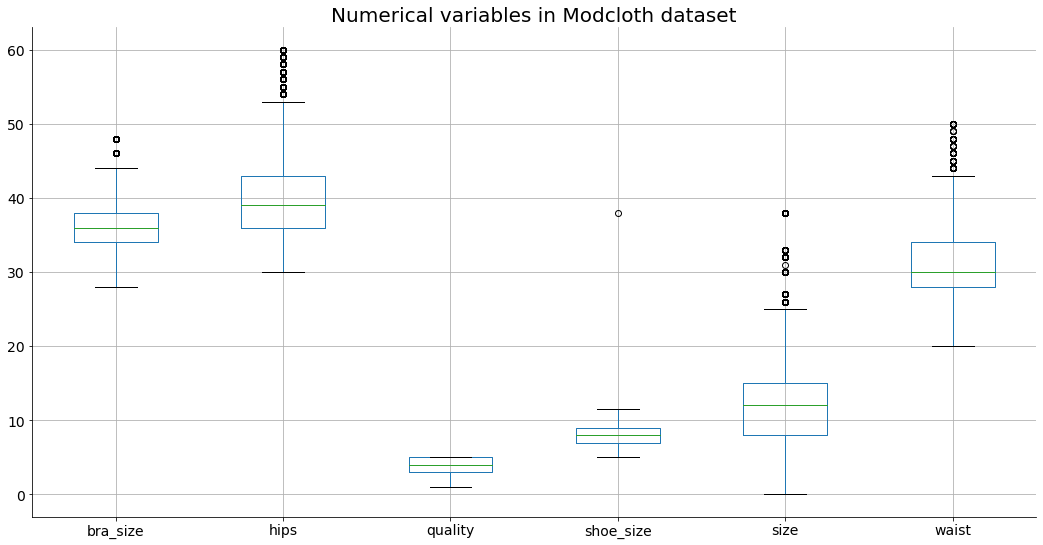

In [7]:
#boxplot
num_cols = ['bra_size','hips','quality','shoe_size','size','waist']
plt.figure(figsize=(18,9))
modcloth[num_cols].boxplot()
plt.title("Numerical variables in Modcloth dataset", fontsize=20)
    
plt.show()

# Outliers
<p> Shoe size has a clear outlier at 38. We will remove that one.</p>

In [8]:
modcloth[modcloth.shoe_size == 38]

,item_id,waist,size,quality,cup_size,hips,bra_size,category,bust,height,user_name,length,fit,user_id,shoe_size,shoe_width,review_summary,review_text
37313,416942,35.0,12,5.0,d,46.0,36.0,new,37-39,5ft 5in,Catslittle,just right,fit,237498,38.0,average,Cardigans are best item Mod Cloth has,"I love these cardigans, my favorite, good fabr..."


<p> Based on the summary of the review, we can assume that the purchaser did not buy a shoe so we can change the shoe size to null for now.</p>

In [9]:
modcloth.at[37313,'shoe_size'] = None

# Data Cleaning & Preprocessing
<p> Update variables and change dtype to the appropriate type for each column. Start with cleaning bra size, cup, and bust. Since cup and bra size are more filled out than bust we will update bust by converting the two sizes into the standard measurement for bra sizing. </p>

In [10]:
#find options of cup size currently in dataset
modcloth.cup_size.unique()

array(['d', 'b', 'dd/e', 'c', 'ddd/f', 'dddd/g', 'i', 'a', nan, 'h', 'aa',
       'j', 'k'], dtype=object)

In [11]:
#create list of conditions for if statement to create difference in inches between underbust and cup
conditions = [
    (modcloth['cup_size'] == 'aa'),
    (modcloth['cup_size'] =='a'),
    (modcloth['cup_size'] == 'b'),
    (modcloth['cup_size'] == 'c'),
    (modcloth['cup_size'] == 'd'),
    (modcloth['cup_size'] == 'dd/e'),
    (modcloth['cup_size'] == 'ddd/f'),
    (modcloth['cup_size'] == 'dddd/g'),
    (modcloth['cup_size'] == 'h'),
    (modcloth['cup_size'] == 'i'),
    (modcloth['cup_size'] == 'j'),
    (modcloth['cup_size'] == 'k')
    ]
# create a list of the values we want to assign for each condition
values = [0,1,2,3,4,5,6,7,8,9,10,11]
# create a new column and use np.select to assign values to it using our lists as arguments
modcloth["dif_undbust_cup"] = np.select(conditions, values)
# display updated DataFrame
modcloth.head()

,item_id,waist,size,quality,cup_size,hips,bra_size,category,bust,height,user_name,length,fit,user_id,shoe_size,shoe_width,review_summary,review_text,dif_undbust_cup
0,123373,29.0,7,5.0,d,38.0,34.0,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN,4
1,123373,31.0,13,3.0,b,30.0,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN,2
2,123373,30.0,7,2.0,b,NaN,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN,2
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN,5
4,123373,NaN,18,5.0,b,NaN,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN,2


In [12]:
# update bust column that combines bra_size and dif_under_bust_cup for a more accurate size
modcloth["bust"] =modcloth["dif_undbust_cup"]+modcloth["bra_size"]
# display updated DataFrame
modcloth.head()

,item_id,waist,size,quality,cup_size,hips,bra_size,category,bust,height,user_name,length,fit,user_id,shoe_size,shoe_width,review_summary,review_text,dif_undbust_cup
0,123373,29.0,7,5.0,d,38.0,34.0,new,38.0,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN,4
1,123373,31.0,13,3.0,b,30.0,36.0,new,38.0,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN,2
2,123373,30.0,7,2.0,b,NaN,32.0,new,34.0,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN,2
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN,5
4,123373,NaN,18,5.0,b,NaN,36.0,new,38.0,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN,2


In [13]:
#look into unique observations which are having less uniqueness
def countplot(indipendent_features):
  plt.figure(figsize=(25, 25))
  for loc, feature in enumerate(indipendent_features):
    ax = plt.subplot(4, 3, loc+1)
    ax.set_xlabel('{}'.format(feature), fontsize=10)
    chart = sns.countplot(modcloth[feature])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
  return None

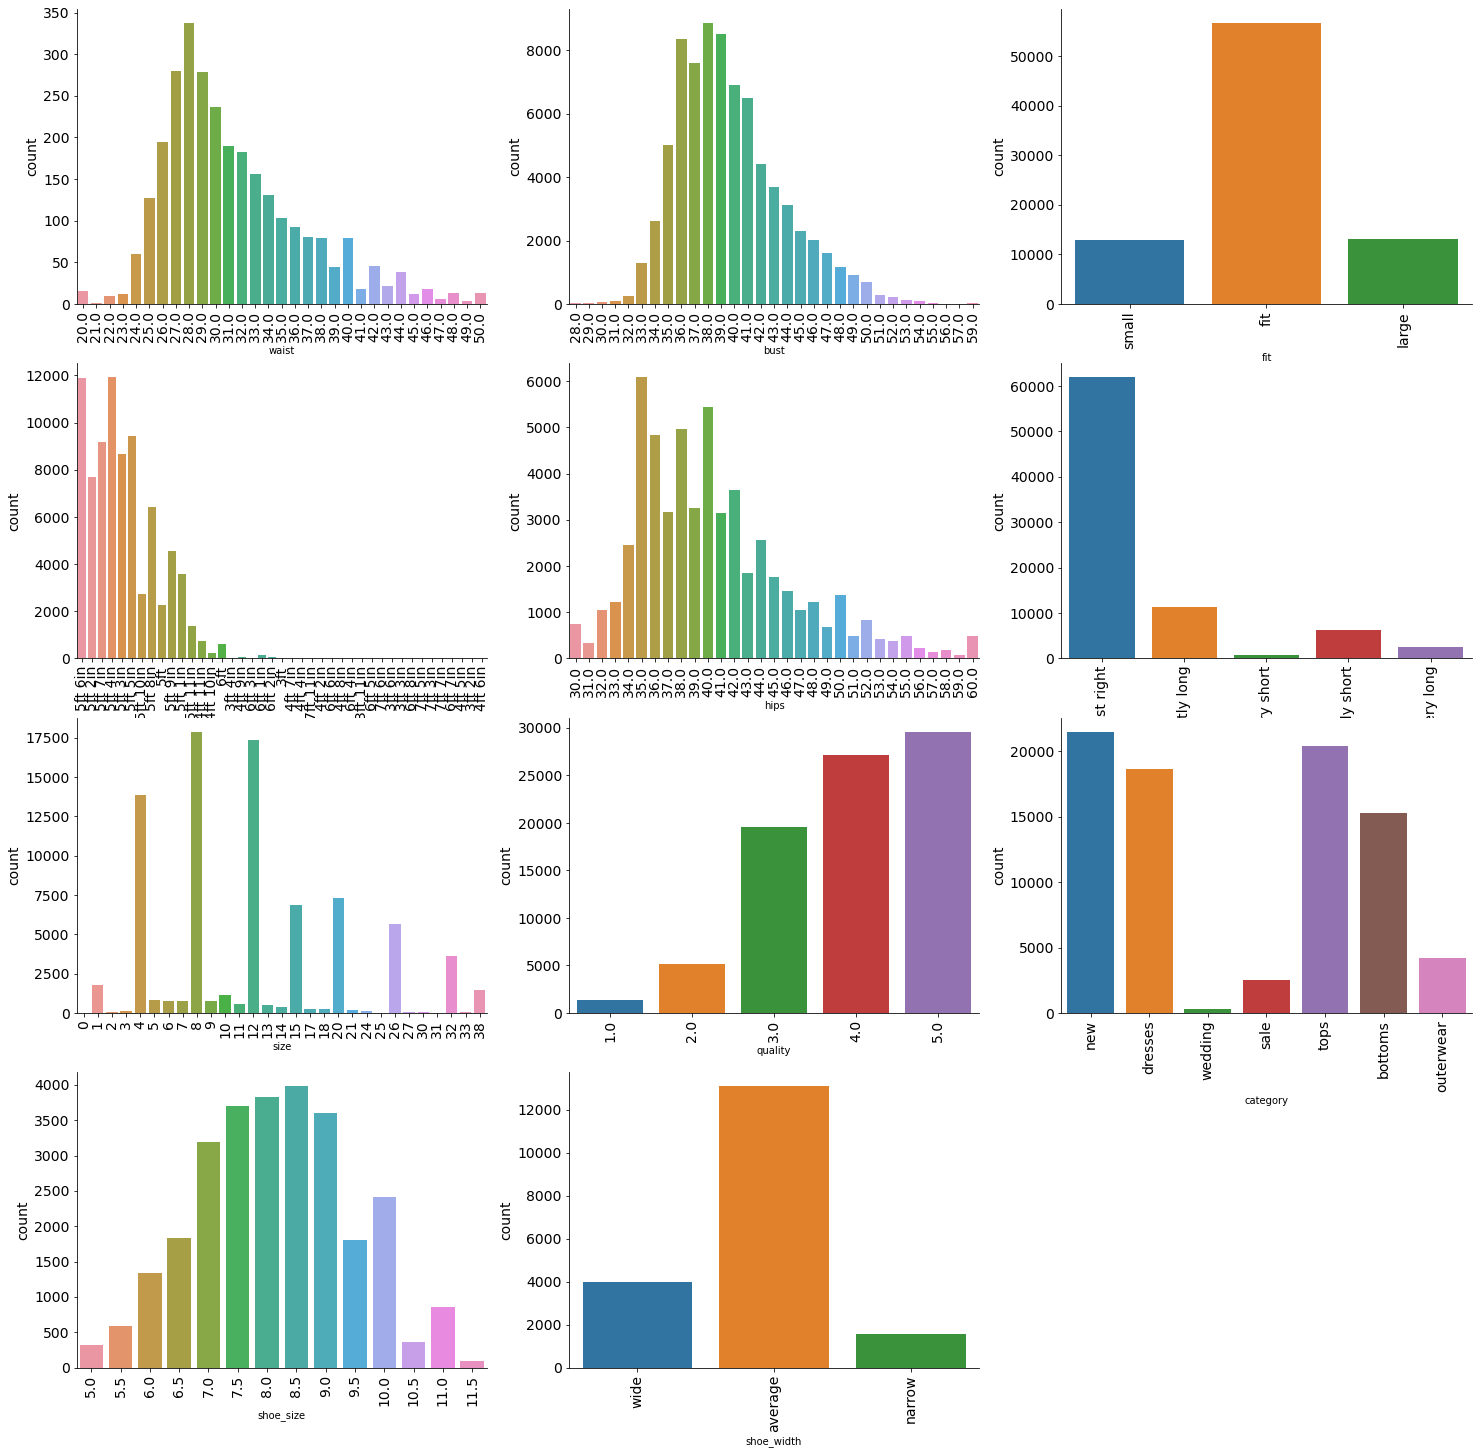

In [14]:
uniques_data = ['waist','bust',  'fit', 'height', 'hips', 'length',  'size', 'quality', 'category',  'shoe_size', 'shoe_width']
countplot(uniques_data)

<p> Next is changing the following variables into category variables (category & fit) and parse the height column</p>


In [15]:
modcloth.bust = modcloth.bust.fillna(0).astype(int)
modcloth.category = modcloth.category.astype('category')
modcloth.fit = modcloth.fit.astype('category')

In [16]:
def get_cms(x):
    if type(x) == type(1.0):
        return
    #print(x)
    try: 
        return (int(x[0])*30.48) + (int(x[4:-2])*2.54)
    except:
        return (int(x[0])*30.48)
modcloth.height = modcloth.height.apply(get_cms)

<p> Since length and quality have so few rows that are missing data, we can remove those rows. For the hips coulmn we will create more unique bins so we don't have to remove and won't lose too much data. </p>


In [17]:
#length 
missing_rows = modcloth[modcloth.length.isnull()].index
modcloth.drop(missing_rows, axis = 0, inplace=True)

#quality
missing_rows = modcloth[modcloth.quality.isnull()].index
modcloth.drop(missing_rows, axis = 0, inplace=True)
modcloth.quality = modcloth.quality.astype('category').cat.as_ordered()

#hips 
modcloth.hips = modcloth.hips.fillna(-1.0)
bins = [-5,0,31,37,40,44,75]
labels = ['Unknown','XS','S','M', 'L','XL']
modcloth.hips = pd.cut(modcloth.hips, bins, labels=labels)

<p>Before we can look at which variable we want to use in the models, we will want to convert the last categorical variables to float to find the correlation between each of the variables. </p>

In [18]:
modcloth.waist = pd.Categorical(modcloth.waist)
modcloth['waist_code'] = modcloth.waist.cat.codes

modcloth.hips = pd.Categorical(modcloth.hips)
modcloth['hips_code'] = modcloth.hips.cat.codes

modcloth.shoe_width = pd.Categorical(modcloth.shoe_width)
modcloth['shoe_width_code'] = modcloth.shoe_width.cat.codes


In [19]:
#drop nonnumeric variables & unneeded columns
modcloth.drop(['waist', 'quality', 'cup_size','hips','user_name','length','user_id','item_id','shoe_width','review_summary','review_text'], axis=1, inplace=True)

<p>Since we are trying to predict the right size for the user, we will want to split our data up into different data sets for each different category, since we know each category of clothes will require different measurments. Note: Dress and wedding will be combined, knowing that their wedding section is under dresses. Also we can assume New & Sale will be our hardest category to predict on, since that is multiple different types of clothing, they will also be combined into Mix.</p>

In [20]:
#find only fit data
modcloth_fit = modcloth.loc[modcloth['fit'] == 'fit']
modcloth_fit.drop('fit', axis=1, inplace=True)
modcloth_fit.bra_size = modcloth_fit.bra_size.fillna(-1.0)
modcloth_fit.height = modcloth_fit.height.fillna(-1.0)
modcloth_fit.shoe_size = modcloth_fit.shoe_size.fillna(-1.0)

#subset data based on categories

mc_mix = modcloth_fit.loc[modcloth_fit['category'].isin(['new','sale'])]

mc_dress = modcloth_fit.loc[modcloth_fit['category'].isin(['dresses','wedding'])]

mc_top = modcloth_fit.loc[modcloth_fit['category'] == 'tops']

mc_bottom = modcloth_fit.loc[modcloth_fit['category'] == 'bottoms']

mc_outerwear = modcloth_fit.loc[modcloth_fit['category'] == 'outerwear']





<p>Now we will find variable importance for each varible in each subset of data.</p>

[0.16065821 0.28519637 0.26025049 0.10403236 0.02285473 0.12941438
 0.03759345]


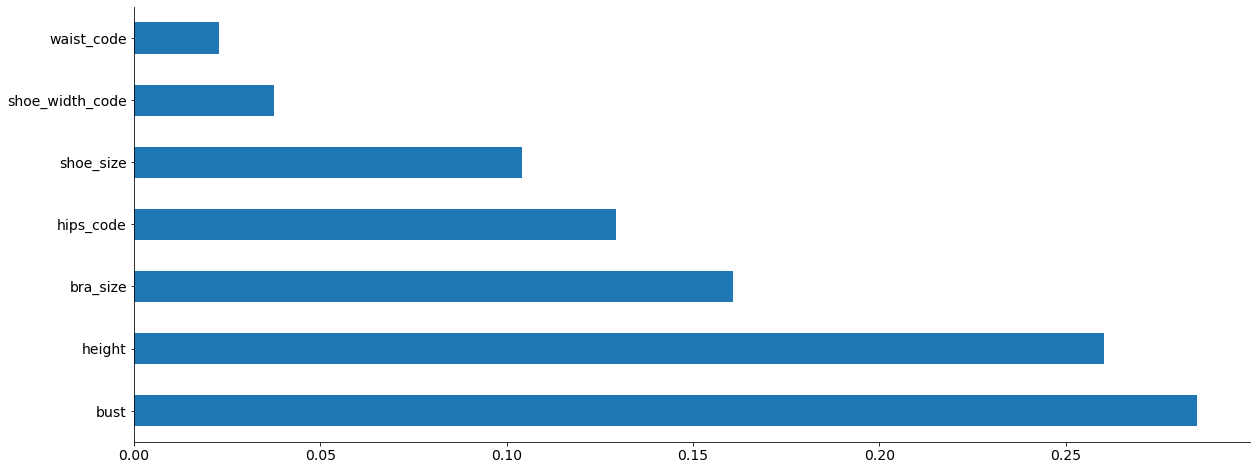

In [21]:
cols =['bra_size','bust','height','shoe_size','waist_code','hips_code','shoe_width_code']
X = mc_mix[cols]  #independent columns
y = mc_mix['size']    #target column 

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

[0.14355717 0.27345451 0.29122352 0.11590505 0.02814598 0.11294729
 0.03476647]


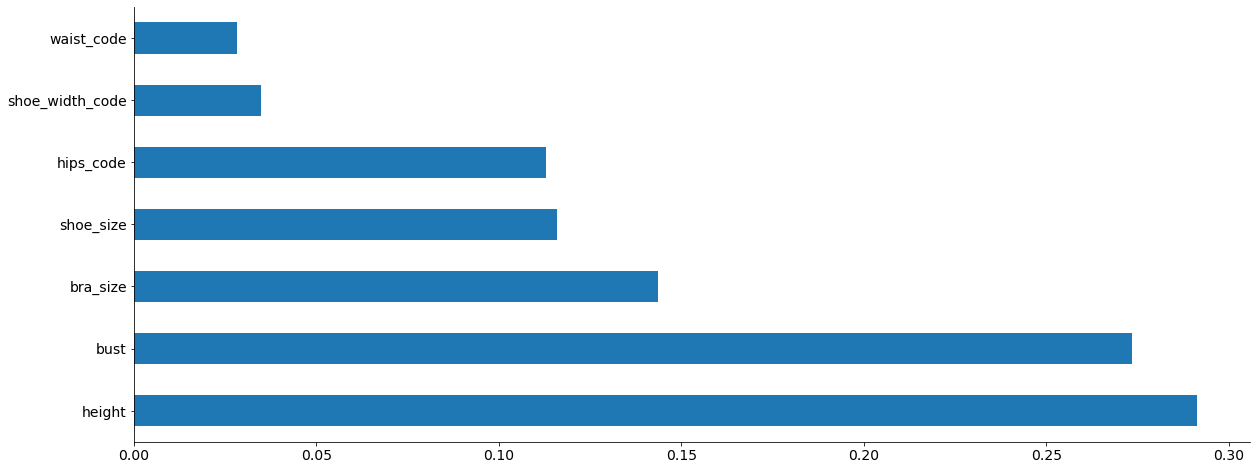

In [22]:
cols =['bra_size','bust','height','shoe_size','waist_code','hips_code','shoe_width_code']
X = mc_dress[cols]  #independent columns
y = mc_dress['size']    #target column 

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

[0.17087903 0.28922153 0.25716118 0.10314424 0.01798694 0.12430505
 0.03730203]


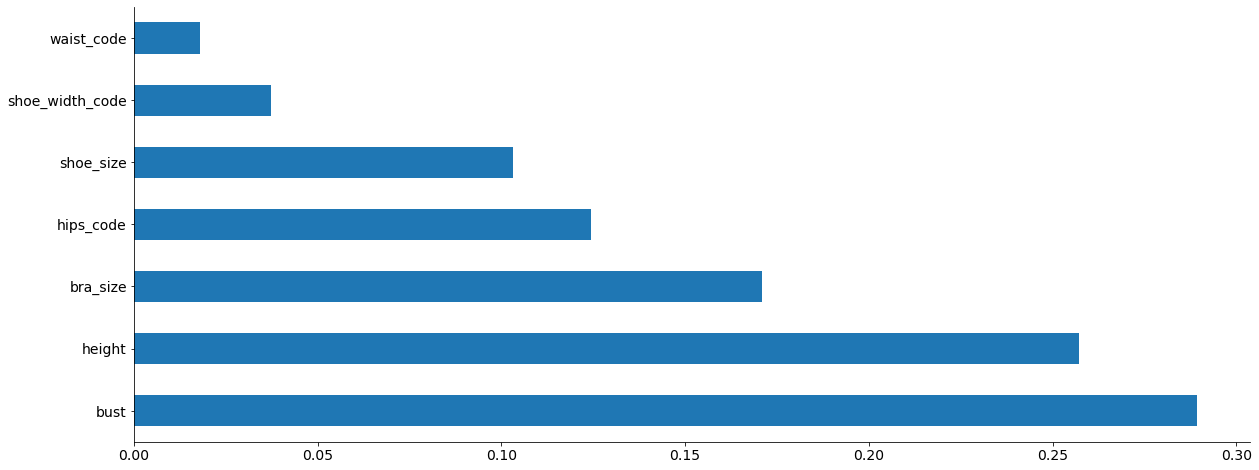

In [23]:
cols =['bra_size','bust','height','shoe_size','waist_code','hips_code','shoe_width_code']
X = mc_top[cols]  #independent columns
y = mc_top['size']    #target column 

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

[0.12669393 0.23703052 0.33204542 0.13733114 0.01953122 0.10514271
 0.04222505]


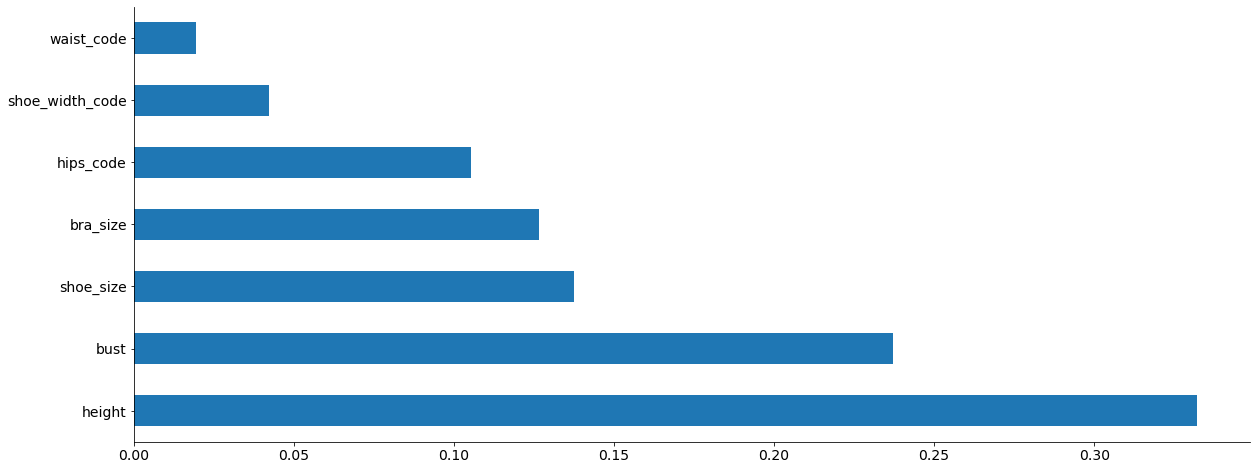

In [24]:
cols =['bra_size','bust','height','shoe_size','waist_code','hips_code','shoe_width_code']
X = mc_bottom[cols]  #independent columns
y = mc_bottom['size']    #target column 

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

[0.15935846 0.27780702 0.28587807 0.09922742 0.01236754 0.12953978
 0.03582171]


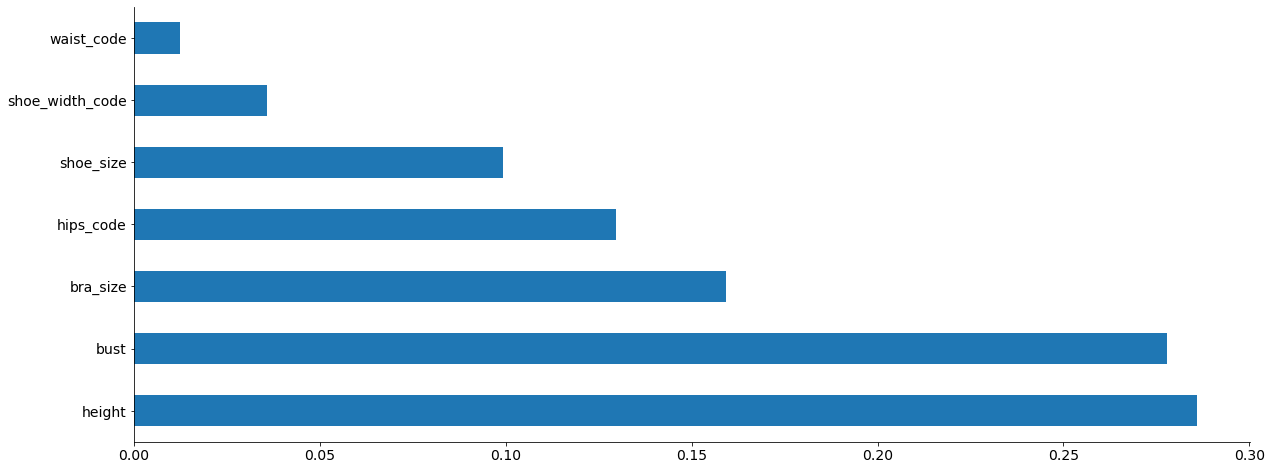

In [25]:
cols =['bra_size','bust','height','shoe_size','waist_code','hips_code','shoe_width_code']
X = mc_outerwear[cols]  #independent columns
y = mc_outerwear['size']    #target column 

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

<p> By subsetting out the data by the category we are able to see how imporant the variables are when looking at size as our x for each different category. We can see that the variables can be more relavent to different categories than others. As we head into modeling. I will chose to only look at the tops subset going forward to predict the correct size for a shopper. I will also  only be looking at bust, height, and hips, because the other variables were not as important and bra_size is heavlily correlated to bust. </p>

# Methods of Models
<p> I trained the model by using the following algorithms </p>
<ul>
  <li>Logistic Regression</li>
  <li>Linear Discriminant Analysis</li>
  <li>KNeighbours</li>
  <li>Decision Trees</li>
  <li>GaussianNB</li>
  <li>SVC</li>
</ul>  

<p> The models used were then compared to each other to find the best model. </p>

In [26]:
#subset with height, bust, hips
cols =['bust','height','hips_code']
X = mc_top[cols]  #independent columns
Y = mc_top['size']    #target column 

# split-out test dataset
mc_test_size = 0.20
seed = 35
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=mc_test_size, random_state=seed)


In [27]:
# Test options and evaluation metric
scoring = 'accuracy'

LR: 0.276821 (0.009837)
LDA: 0.286918 (0.009981)
KNN: 0.430236 (0.019589)
CART: 0.467667 (0.012848)
NB: 0.331016 (0.017406)
SVM: 0.309245 (0.013931)


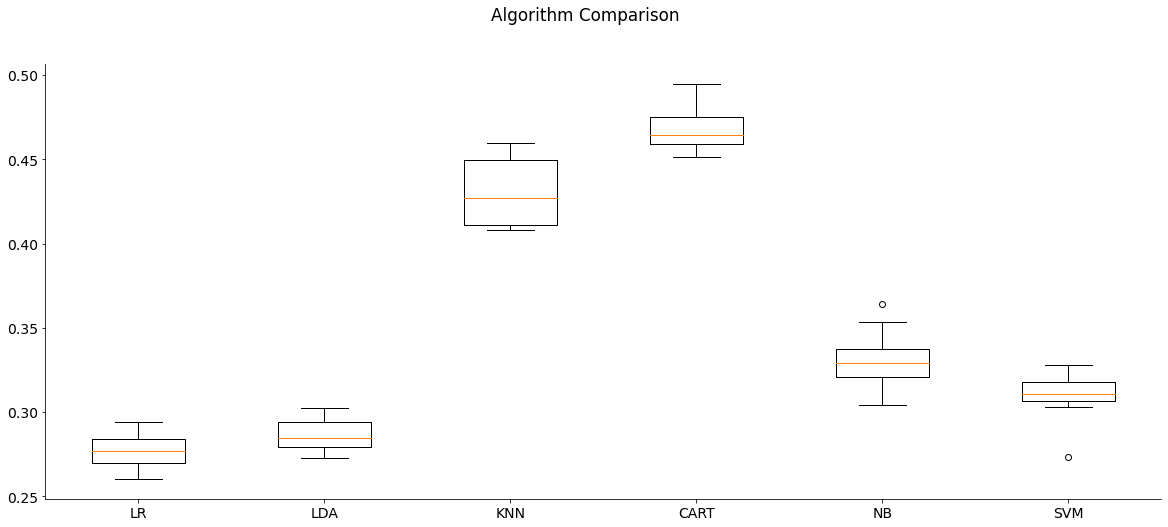

In [28]:
# Spot Check Algorithms
names = ['bust','height','hips', 'size']
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

<p> The accuracy scores and standard deviation of each algorithm is shown, together with the box and whisker plot showing the spread of the accuracy scores across each cross-validation fold for each algorithm.</p>

<p> CART is the most accurate model with an accuracy score of 0.468, followed by KNN and NB which have an accuracy score of 0.430 and 0.331 respectively. CART also has the lowest standard deviation and smallest spread of accuracy scores among the 3 models. A smaller standard deviation is ideal as it means better consistency, predictability and quality.</p>

In [29]:
# make predictions on test dataset
CART = DecisionTreeClassifier()
CART.fit(X_train, Y_train)
predictions = CART.predict(X_test)
print("Accuracy:")
print(accuracy_score(Y_test, predictions))
print()
print("Confusion matrix:")
print(confusion_matrix(Y_test, predictions))
print()
print("Classification report:")
print(classification_report(Y_test, predictions))

Accuracy:
0.473508706928492

Confusion matrix:
[[  0   0   2   0   0   0   0   0   0   0   0   0   0]
 [  0   0  37   0   0   3   0   0   0   0   0   0   0]
 [  0   9 332   0   0 166   0  40   1   1   0   1   0]
 [  0   0   2   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   3 159   0   0 354   0 156   4   5   1   1   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0  31   0   0 174   0 368   8  52  13   0   0]
 [  0   0   2   0   0   9   0  74   5  27  12   5   0]
 [  0   0   2   0   0  14   0  85  10 110  30   9   4]
 [  0   0   4   0   0   6   0  24   8  69  64  17   5]
 [  0   0   1   0   0   8   0  10   1  28  30  32  10]
 [  0   0   0   0   0   2   0   2   0   9  20  13  13]]

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        40
           4       0.58      0.60      0.59       

In [30]:
mc_top.describe()

,size,bra_size,bust,height,shoe_size,dif_undbust_cup,waist_code,hips_code,shoe_width_code
count,13493.000000,13493.000000,13493.000000,13493.000000,13493.000000,13493.000000,13493.000000,13493.000000,13493.000000
mean,12.678945,33.835248,37.348773,163.435784,2.192322,3.455495,-0.681909,2.186171,-0.657897
std,8.401198,9.417447,10.273299,20.514783,4.436497,1.825644,2.121927,1.798564,0.727812
min,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000
25%,8.000000,34.000000,36.000000,160.020000,-1.000000,2.000000,-1.000000,0.000000,-1.000000
50%,12.000000,36.000000,39.000000,165.100000,-1.000000,3.000000,-1.000000,2.000000,-1.000000
75%,15.000000,38.000000,42.000000,170.180000,7.500000,5.000000,-1.000000,4.000000,-1.000000
max,38.000000,48.000000,59.000000,241.300000,11.500000,11.000000,30.000000,5.000000,2.000000


# Results
<p> Predicting Size with Decision Tree Model based on </p>
<ul>
  <li>36in Bust</li>
  <li>165in Height</li>
  <li>2 hips code</li>
</ul>  

In [31]:
print(CART.predict([[36,165,2]]))

[4]


<p> Predicting Size with Decision Tree Model based on </p>
<ul>
  <li>38in Bust</li>
  <li>170in Height</li>
  <li>3 hips code</li>
</ul>  

In [32]:
print(CART.predict([[38,170,3]]))

[8]
